# Reversal / Momentum - Time Horizon
In this homework, we explore how reversal tends to exist at shorter horizons and momentum at longer horizons. We do this on 4h cryptocurrency price data. Please first run the code below, which will download the price data (from Binance since 01/2020 to 12/2022) and compute returns based on it, stored in `ret`.

1. Use `ret` to generate rank-demeaned-normalized XS reversal strategies at 4,8,12,16,20, and 24 hour frequencies.
2. IE. for the 12 hour strategy, you will use the average return in the last three 4-hour bars to form a rank-demeaned-noramlzied XS portfolio and hold for the 4 hours.
3. Compute the Sharpe ratios of the reversal strategy at these different horizons.
4. At what horizons do you observe reversal vs. momentum?
5. The first bar typically contains the most reversal. "Skip" the first bar by lagging your portfolio by one 4h bar (similar to how UMD does at the monthly frequency). This should strengthen any momentum you see.

In [4]:
from binance.client import Client as bnb_client
from datetime import datetime
import pandas as pd 
import numpy as np 

client = bnb_client()
###  if you're in the US, use: 
### "client = bnb_client(tld='US')" here instead

def get_binance_px(symbol,freq,start_ts = '2020-01-01'):
    data = client.get_historical_klines(symbol,freq,start_ts)
    columns = ['open_time','open','high','low','close','volume','close_time','quote_volume',
    'num_trades','taker_base_volume','taker_quote_volume','ignore']

    data = pd.DataFrame(data,columns = columns)
    
    # Convert from POSIX timestamp (number of millisecond since jan 1, 1970)
    data['open_time'] = data['open_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    data['close_time'] = data['close_time'].map(lambda x: datetime.utcfromtimestamp(x/1000))
    return data 

univ = ['BTCUSDT','ETHUSDT','ADAUSDT','BNBUSDT','XRPUSDT','DOTUSDT','MATICUSDT']

freq = '4h'
px = {}
for x in univ:
    data = get_binance_px(x,freq)
    px[x] = data.set_index('open_time')['close']

px = pd.DataFrame(px).astype(float)
px = px.reindex(pd.date_range(px.index[0],px.index[-1],freq=freq))
ret = px.pct_change()

/tmp/ipykernel_68422/1009615908.py:32: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Call ffill before calling pct_change to retain current behavior and silence this warning.
  ret = px.pct_change()


In [5]:
ret

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,-0.002101,0.000307,0.003633,-0.004067,0.002114,NaN,0.018012
2020-01-01 08:00:00,-0.001752,0.003839,-0.000905,-0.003038,-0.004116,NaN,0.067233
2020-01-01 12:00:00,0.005139,0.010249,0.013889,0.007530,0.001860,NaN,-0.003316
2020-01-01 16:00:00,-0.000651,-0.001666,0.001191,-0.007191,0.000052,NaN,-0.005988
...,...,...,...,...,...,...,...
2024-08-20 00:00:00,0.019864,0.009722,0.013959,0.019699,0.016374,0.020977,0.028133
2024-08-20 04:00:00,0.005034,0.004816,0.007909,-0.000702,-0.002301,0.000437,0.001809
2024-08-20 08:00:00,-0.006656,-0.012098,0.000291,-0.001757,0.003131,-0.010924,-0.009481
2024-08-20 12:00:00,-0.027980,-0.025529,-0.014526,-0.011444,-0.031373,-0.005964,0.011623


In [6]:
#4hrs one
negate = ret *-1
ranked = negate.rank(1)
demeaned = ranked.subtract(ranked.mean(1),0)
port = demeaned.divide(demeaned.abs().sum(1),0)

In [ ]:
def returns(freq):
    negate = ret.rolling(freq).sum() *-1
    ranked = negate.rank(1)
    demeaned = ranked.subtract(ranked.mean(1),0)
    port = demeaned.divide(demeaned.abs().sum(1),0)
    net_returns = port.shift() * ret
    total_returns = net_returns.sum(1)


In [7]:
port

,BTCUSDT,ETHUSDT,ADAUSDT,BNBUSDT,XRPUSDT,DOTUSDT,MATICUSDT
2020-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-01 04:00:00,0.166667,0.055556,-0.166667,0.277778,-0.055556,NaN,-0.277778
2020-01-01 08:00:00,0.055556,-0.166667,-0.055556,0.166667,0.277778,NaN,-0.277778
2020-01-01 12:00:00,0.055556,-0.166667,-0.277778,-0.055556,0.166667,NaN,0.277778
2020-01-01 16:00:00,-0.055556,0.055556,-0.277778,0.277778,-0.166667,NaN,0.166667
...,...,...,...,...,...,...,...
2024-08-20 00:00:00,-0.083333,0.250000,0.166667,0.000000,0.083333,-0.166667,-0.250000
2024-08-20 04:00:00,-0.166667,-0.083333,-0.250000,0.166667,0.250000,0.083333,0.000000
2024-08-20 08:00:00,0.000000,0.250000,-0.166667,-0.083333,-0.250000,0.166667,0.083333
2024-08-20 12:00:00,0.166667,0.083333,0.000000,-0.083333,0.250000,-0.166667,-0.250000


<Axes: >

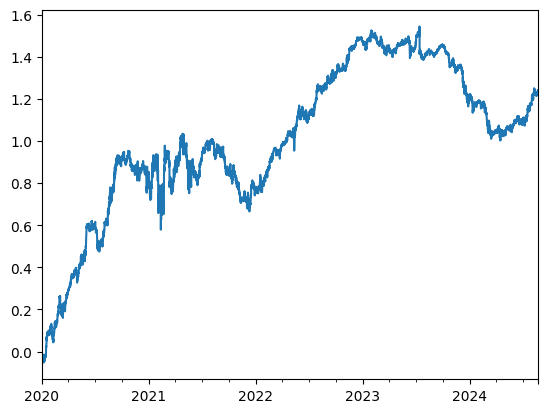

In [10]:
net_returns = port.shift() * ret
total_returns = net_returns.sum(1)
cum = total_returns.cumsum()
cum.plot()